In [17]:
# some useful mysklearn package import statements and reloads
import importlib
import os
from matplotlib import pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import utils
importlib.reload(utils)
import utils as utils

In [18]:
fpath = os.path.join("Data/beer_reviews_cleaned.csv")
table = MyPyTable().load_from_file(fpath)

## Data Analysis

### Beer Styles
We need to better understand the different values for the style of beer in order to make decisions on how to treat that attribute. If there are too many different styles, then we will need to combine similar styles. We will count the number of instances with each style and make a bar chart displaying the frequencies of each beer style.

First, we need to count the frequencies of each style. This can be done with the code.

In [19]:
styles = table.get_column("beer_style")

style_counts = {}
for style in styles:
    if style not in style_counts:
        style_counts[style] = 1
    else:
        style_counts[style] += 1


Now that the counts of all of the styles are stored in a dictionary, we can use matplotlib to create a bar chart using `plt.bar()`.

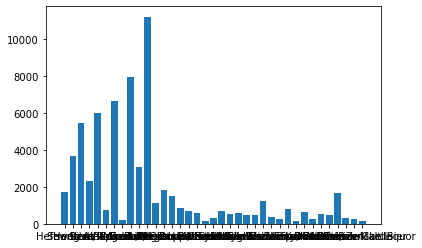

In [20]:
plt.bar(style_counts.keys(), style_counts.values())

plt.show()

### Classification

In [21]:
table = table.get_columns(['beer_style', 'beer_abv', 'rating'])
table.remove_rows_with_missing_values()

X = table.get_columns(['beer_style', 'beer_abv']).data
y = table.get_column('rating')

In [22]:
X_train, X_test, y_train, y_test = myevaluation.train_test_split(X, y, .25, random_state=30, shuffle=True)

kNN_clf = MyKNeighborsClassifier(n_neighbors=10)
#kNN_clf.fit(X_train, y_train)
#kNN_y_predicted = kNN_clf.predict(X_test)

#kNN_acc = myevaluation.accuracy_score(y_test, kNN_y_predicted)

In [23]:
#print(kNN_acc)

In [24]:
nb_clf = MyDummyClassifier()
nb_clf.fit(X_train, y_train)
nb_y_predicted = nb_clf.predict(X_test)

nb_acc = myevaluation.accuracy_score(y_test, nb_y_predicted)
print(nb_acc)

0.7607116624500122


In [25]:
# X_train_folds, X_test_folds = myevaluation.stratified_kfold_cross_validation(X, y, 10, random_state=0, shuffle=True)

# dummy_y_pred = []
# knn_y_pred = []
# nb_y_pred = []
# dt_y_pred = []
# y_true = []
# for fold in range(len(X_train_folds)):
#     X_train = [X[index] for index in X_train_folds[fold]]
#     y_train = [y[index] for index in X_train_folds[fold]]
#     X_test = [X[index] for index in X_test_folds[fold]]
#     y_test = [y[index] for index in X_test_folds[fold]]

#     # dummy_clf = MyDummyClassifier()
#     # dummy_clf.fit(X_train, y_train)
#     # dummy_y_pred.extend(dummy_clf.predict(X_test))

#     knn_clf = MyKNeighborsClassifier(5)
#     knn_clf.fit(X_train, y_train)
#     knn_y_pred.extend(knn_clf.predict(X_test))

#     # nb_clf = MyNaiveBayesClassifier()
#     # nb_clf.fit(X_train, y_train)
#     # nb_y_pred.extend(nb_clf.predict(X_test))

#     # dt_clf = MyDecisionTreeClassifier()
#     # dt_clf.fit(X_train, y_train)
#     # dt_y_pred.extend(dt_clf.predict(X_test))

#     y_true.extend(y_test)